In [1]:
import utils as ut
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Load paths
samples='sample_matrix.csv'
results='results.txt'
results_new='results.csv'
path_EML='EML21/'
path_MD3='MD3/'
path_MD1='MD1/'
path_TK='TK/'
path_USPrr='US-Prr/SA/'

In [4]:
def plot_r2_rmse(df_y):
    ''' plots R2 v.s. RMSE, with the condition that last row of the dataframe are targets
        df_y: model output dataframe
    '''
    [n,m]=np.shape(df_y)
    r2=[r2_score(y_short[iname], y_long[iname].iloc[-1]) for iname in y_long.columns]
    r2=[r2_score(df_y.iloc[i,:], df_y.iloc[-1,:]) for i in range(n-1)]
    rmse=[mean_squared_error((y_short[iname], y_long[iname].iloc[-1]) for iname in y_long.columns)]
    r2=np.asarray(r2)
    rmse=np.asarray(rmse)
    plt.plot(rmse,r2,'o'), plt.xlabel('RMSE'), plt.ylabel('$R^2$');
    
    return rmse

In [9]:
#Load Functions
def read_samples_resutls(paths,pathr):
    df_param = pd.read_csv(paths)
    df_model = pd.read_csv(pathr,header=None)
    return [df_param,df_model]

def z_score(y_short,y_long):
    '''
    NOTE: this function assumes that last row in y_long is target
    
    y_short: model dataframe restricted by R2
    y_long : full model dataframe 
    '''
    zscore=[]
    for iname in y_long.columns:
        zscore.append((y_short[iname].mean()-y_long[iname].iloc[-1])/y_short[iname].std())
    df_z = pd.DataFrame(zscore)
    df_z.index = y_long.columns
    
    return df_z

def rmse(x,x_true):
    MSE = np.square(np.subtract(x.mean(),x_true)) 
    df_z = pd.DataFrame(np.sqrt(MSE))
    df_z.index = x.columns
    return df_z

def relative_error(x,x_true):
    MAE = np.subtract(x.mean(),x_true)
    df_z = pd.DataFrame(abs(100*MAE/x_true))
    df_z.index = x.columns
    return df_z

def get_by_index(zscore,index_list):
    return pd.Series([zscore[0][iname] for iname in index_list])

def nmae_score(ymodel,df_model):
    # MAE is computed by taking the absolute difference between each target value and its corresponding 
    # model output value (over all runs), and then taking the average of these absolute differences. n=num simulations
    # MAE = (1 / n) * Σ|target_i - model_i|
    # Calculate the mean of the absolute values of the target values.
    # Mean Absolute Target Value = (1 / n) * Σ|target_i|
    # NMAE = (MAE / Mean Absolute Target Value) * 100

    '''    
    df_model: model dataframe
    ymodel: full dataframe constrained by error
    '''
    targets = df_model.iloc[-1, :]
    [n,m]=np.shape(ymodel)
    df=(abs(ymodel.iloc[:-1,:] - df_model.iloc[-1, :]))
    column_sums = df.sum(axis=0)
    mae = column_sums /(n-1) 
    mean_abs_target = np.abs(targets).mean()
    nmae = (mae / mean_abs_target) * 100
    df_nmae = pd.DataFrame(nmae)
    nmae = get_by_index(df_nmae,list(df_model.columns))
    df_nmae_score = pd.DataFrame(nmae)
    df_nmae_score.index = df_model.columns
    
    return  df_nmae_score

def site_metric_matrix(metric_matrix, metric, colorb=False):
    '''    
    metric_matrix: matrix (dataframe) of metric to plot. cols = sites, rows = targets
    metric: string of the name of the metric, ex; 'NMAE'
    '''
 
    n_rows, n_cols = metric_matrix.shape
    sns.set(font_scale=1.2)  
    
    if colorb:
        fig, ax = plt.subplots(figsize=(6, 10))
        sns.heatmap(metric_matrix, cmap="coolwarm", vmin = -2, vmax = 2,annot=True, fmt=".2f",
                   cbar_kws={'label': 'relative score',"orientation": 'horizontal'},
                   annot_kws={"fontsize":11})
    else:
        fig, ax = plt.subplots(figsize=(6, 8))
        sns.heatmap(metric_matrix, cmap="coolwarm", vmin = -2, vmax = 2,annot=True, fmt=".2f",
                   cbar=False,
                    #cbar_kws={'label': 'relative score',"orientation": 'horizontal'},
                   annot_kws={"fontsize":11})
        
        
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Plant Functional Types')
    ax.set_ylabel('Targets')
    ax.set_title(metric + ' Matrix')
    plt.show()
    return

In [12]:
# Load EML21
rmetric='r2rmse'
nelem=10
order=True

sa_folder='sa_cmax_EML21_090_AK/'
[df_param_EML,df_model_EML0]=read_samples_resutls(path_EML+sa_folder+samples,
                                                    path_EML+sa_folder+results)
output_name = ['GPP0','GPP1','GPP2','GPP3','GPP4','GPP5','GPP6','NA','NA']
df_model_EML0.columns = output_name
df_model_EML=df_model_EML0.iloc[:,:-2].copy()
xparams_EML, ymodel_EML =  ut.get_best_match(df_param_EML,df_model_EML)
xparams_EML

if metric == 'zscore':
    gpp_eml = z_score(ymodel_EML.sort_values(by=[rm
                                                    etric],ascending=order)[:nelem],
                    df_model_EML)
elif metric == 'nmae':
    gpp_eml = nmae_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                    df_model_EML)
else:
    gpp_eml = rmse_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                    df_model_EML)

,cmax,cmax.1,cmax.2,cmax.3,cmax.4,cmax.5,cmax.6,R2,RMSE,MAPE,COMBINED_ACC,r2rmse,r2rmsemape
0,28.859824,249.522861,529.757395,3.515707,15.744447,49.199589,23.997595,0.895310,2092.173387,0.387424,0.499470,0.312985,0.656478
1,45.083813,189.391782,519.471208,1.665870,35.277836,99.933198,30.630582,0.908559,1586.528929,0.327540,0.601295,0.241641,0.544431
2,22.500224,117.545576,345.824164,3.279221,22.366680,59.342186,47.809674,0.901489,703.626336,0.293412,0.686777,0.139802,0.458849
3,21.103297,136.248880,372.535593,3.059424,30.844223,52.475534,43.612081,0.961899,331.891428,0.272611,0.791826,0.060341,0.410509
4,36.049681,93.989471,476.244286,2.145677,13.561238,108.666415,63.022177,0.889710,1597.618956,0.529974,0.403147,0.250787,0.828271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20.673320,230.919374,370.738089,3.713503,23.299594,52.419733,47.372524,0.982579,166.554222,0.239550,0.853355,0.029238,0.358004
996,18.502541,157.094903,450.044424,2.995350,29.968132,99.594372,54.663452,0.959075,518.683290,0.285769,0.764185,0.083798,0.433820
997,17.780827,119.390149,445.741229,4.591431,32.038963,100.690088,34.537952,0.937703,788.371209,0.383307,0.637723,0.127414,0.584976
998,30.671781,166.961423,282.669781,1.699418,34.725670,55.553444,31.817803,0.743080,1250.697690,0.334380,0.453541,0.311606,0.587501


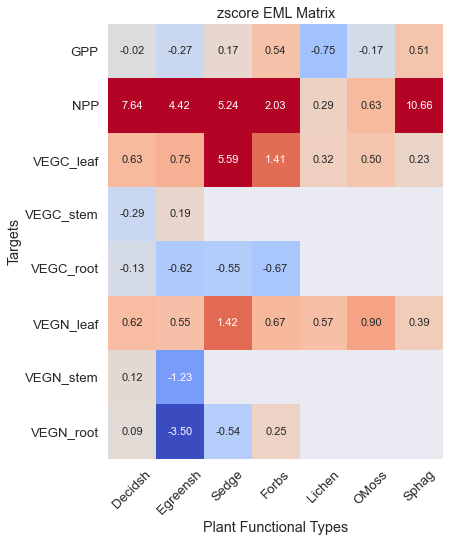

In [10]:
# Load EML21
rmetric='r2rmse'
nelem=10
order=True

def plot_EML(rmetric='r2rmse', nelem=10, order=True, metric='zscore', site=''):
    # metric: zscore, nmae_score
    #GPP
    sa_folder='sa_cmax_EML21_090_AK/'
    [df_param_EML,df_model_EML0]=read_samples_resutls(path_EML+sa_folder+samples,
                                                     path_EML+sa_folder+results)
    output_name = ['GPP0','GPP1','GPP2','GPP3','GPP4','GPP5','GPP6','NA','NA']
    df_model_EML0.columns = output_name
    df_model_EML=df_model_EML0.iloc[:,:-2].copy()
    xparams_EML, ymodel_EML =  ut.get_best_match(df_param_EML,df_model_EML)
    
    if metric == 'zscore':
        gpp_eml = z_score(ymodel_EML.sort_values(by=[rm
                                                     etric],ascending=order)[:nelem],
                        df_model_EML)
    elif metric == 'nmae':
        gpp_eml = nmae_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
    else:
        gpp_eml = rmse_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
        
    gpp_eml=get_by_index(gpp_eml,['GPP0','GPP1','GPP2','GPP3','GPP4','GPP5','GPP6'])
        

    # NPP
    sa_folder='sa_nmaxkrb_EML21_090_AK-2/'
    [df_param_EML,df_model_EML]=read_samples_resutls(path_EML+sa_folder+samples,
                                                     path_EML+sa_folder+results)
    output_name = ['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6',
                   'VEGC00','VEGC10','VEGC20',
                   'VEGC01','VEGC11','VEGC21', 
                   'VEGC02','VEGC22','VEGC03','VEGC23','VEGC04','VEGC05','VEGC06']
    df_model_EML.columns = output_name
    xparams_EML, ymodel_EML =  ut.get_best_match(df_param_EML,df_model_EML)

    if metric == 'zscore':
        npp_eml = z_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
    elif metric == 'nmae':
        npp_eml = nmae_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
    else:
        npp_eml = rmse_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
    
    npp_eml=get_by_index(npp_eml,['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6'])

    #VEGC
    sa_folder = 'sa_nmaxkrbcfallnfall_EML21_090_AK-2/'
    df_param_EML = pd.read_csv(path_EML+sa_folder+samples)
    df_model_EML = pd.read_csv(path_EML+sa_folder+results,header=None)

    output_name = ['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6',
                   'VEGC00','VEGC10','VEGC20',
                   'VEGC01','VEGC11','VEGC21', 
                   'VEGC02','VEGC22','VEGC03','VEGC23','VEGC04','VEGC05','VEGC06',
                   'VEGN00','VEGN10','VEGN20',
                   'VEGN01','VEGN11','VEGN21', 
                   'VEGN02','VEGN22','VEGN03','VEGN23','VEGN04','VEGN05','VEGN06']
    df_model_EML.columns = output_name

    xparams_EML, ymodel_EML =  ut.get_best_match(df_param_EML,df_model_EML)
    
    if metric == 'zscore':
        vegc_eml = z_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
    elif metric == 'nmae':
        vegc_eml = nmae_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)
    else:
        vegc_eml = rmse_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_EML)

    
    #z_eml = z_score(ymodel_EML.sort_values(by=[rmetric],ascending=order)[:nelem],df_model_EML)
    vegc_eml_leaf=get_by_index(vegc_eml,['VEGC00','VEGC01','VEGC02','VEGC03','VEGC04','VEGC05','VEGC06'])
    vegc_eml_stem=get_by_index(vegc_eml,['VEGC10','VEGC11'])
    vegc_eml_root=get_by_index(vegc_eml,['VEGC20','VEGC21','VEGC22','VEGC23',])

    #VEGN
    vegn_eml_leaf=get_by_index(vegc_eml,['VEGN00','VEGN01','VEGN02','VEGN03','VEGN04','VEGN05','VEGN06'])
    vegn_eml_stem=get_by_index(vegc_eml,['VEGN10','VEGN11'])
    vegn_eml_root=get_by_index(vegc_eml,['VEGN20','VEGN21','VEGN22','VEGN23',])

    #new
    z_eml_matrix = pd.DataFrame({
             'GPP': gpp_eml,
             'NPP': npp_eml,
             'VEGC_leaf': vegc_eml_leaf, 'VEGC_stem': vegc_eml_stem, 'VEGC_root': vegc_eml_root,
             'VEGN_leaf': vegn_eml_leaf, 'VEGN_stem': vegn_eml_stem, 'VEGN_root': vegn_eml_root
            })
    z_eml_matrix.index=['Decidsh', 'Egreensh', 'Sedge', 'Forbs', 'Lichen', 'OMoss', 'Sphag']
    
    site_metric_matrix(z_eml_matrix.T, metric+' '+site)
    
plot_EML(rmetric, nelem, order, metric='zscore', site='EML')

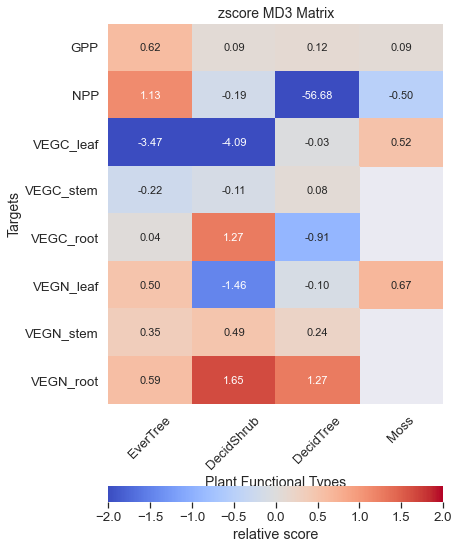

In [16]:
# Load MD3
def plot_MD3(rmetric='r2rmse', nelem=10, order=True, metric='zscore', site=''):
    # metric: zscore, nmae_score
    #GPP
    sa_folder = 'sa_cmax_MD3_050_AK/'
    [df_param_MD3,df_model_MD3]=read_samples_resutls(path_MD3+sa_folder+samples,
                                                     path_MD3+sa_folder+results)
    output_name_MD3 = ['GPP0','GPP1','GPP2','GPP3']
    df_model_MD3.columns = output_name_MD3
    xparams_MD3, ymodel_MD3 =  ut.get_best_match(df_param_MD3,df_model_MD3)

    #z_gpp_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
    #                    df_model_MD3)

    if metric == 'zscore':
        gpp_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD3)
    else:
        gpp_md3 = nmae_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD3)
        
    gpp_md3=get_by_index(gpp_md3,['GPP0','GPP1','GPP2','GPP3'])

    # NPP
    sa_folder = 'sa_nmaxkrb_MD3_090_AK/'
    [df_param_MD3,df_model_MD3]=read_samples_resutls(path_MD3+sa_folder+samples,
                                                     path_MD3+sa_folder+results)
    output_name_MD3 = ['NPP0','NPP1','NPP2','NPP3',\
                       'VEGC00','VEGC10','VEGC20',\
                       'VEGC01','VEGC11','VEGC21',\
                       'VEGC02','VEGC12','VEGC22',\
                       'VEGC03'
                       ]
    df_model_MD3.columns = output_name_MD3
    xparams_MD3, ymodel_MD3 =  ut.get_best_match(df_param_MD3,df_model_MD3)
    #z_npp_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],df_model_MD3)
    if metric == 'zscore':
        npp_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD3)
    else:
        npp_md3 = nmae_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD3)
    
    npp_md3=get_by_index(npp_md3,['NPP0','NPP1','NPP2','NPP3'])

    #VEGC
    sa_folder = 'sa_nmaxkrbcfallnfall_MD3_090_AK/'
    df_param_MD3 = pd.read_csv(path_MD3+sa_folder+samples)
    df_model_MD3 = pd.read_csv(path_MD3+sa_folder+results_new,header=None)

    output_name_MD3 = ['NPP0','NPP1','NPP2','NPP3',
                    'VEGC00','VEGC10','VEGC20',
                    'VEGC01','VEGC11','VEGC21',
                    'VEGC02','VEGC12','VEGC22','VEGC03',
                    'VEGN00','VEGN10','VEGN20',
                    'VEGN01','VEGN11','VEGN21',
                    'VEGN02','VEGN12','VEGN22','VEGN03']
    df_model_MD3.columns = output_name_MD3
    xparams_MD3, ymodel_MD3 =  ut.get_best_match(df_param_MD3,df_model_MD3)
    
    if metric == 'zscore':
        vegc_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD3)
    else:
        vegc_md3 = nmae_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD3)

#    z_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=order)[:nelem],df_model_MD3)
    
    vegc_md3_leaf=get_by_index(vegc_md3,['VEGC00','VEGC01','VEGC02','VEGC03'])
    vegc_md3_stem=get_by_index(vegc_md3,['VEGC10','VEGC11','VEGC12'])
    vegc_md3_root=get_by_index(vegc_md3,['VEGC20','VEGC21','VEGC22'])

    #VEGN
    vegn_md3_leaf=get_by_index(vegc_md3,['VEGN00','VEGN01','VEGN02','VEGN03'])
    vegn_md3_stem=get_by_index(vegc_md3,['VEGN10','VEGN11','VEGN12'])
    vegn_md3_root=get_by_index(vegc_md3,['VEGN20','VEGN21','VEGN22'])

    #new
    z_md3_matrix = pd.DataFrame({
             'GPP': gpp_md3,
             'NPP': npp_md3,
             'VEGC_leaf': vegc_md3_leaf, 'VEGC_stem': vegc_md3_stem, 'VEGC_root': vegc_md3_root,
             'VEGN_leaf': vegn_md3_leaf, 'VEGN_stem': vegn_md3_stem, 'VEGN_root': vegn_md3_root
            })
    z_md3_matrix.index=['EverTree', 'DecidShrub', 'DecidTree', 'Moss']

    site_metric_matrix(z_md3_matrix.T, metric+' '+site)
    
plot_MD3(rmetric, nelem, order, metric='zscore', site='MD3')


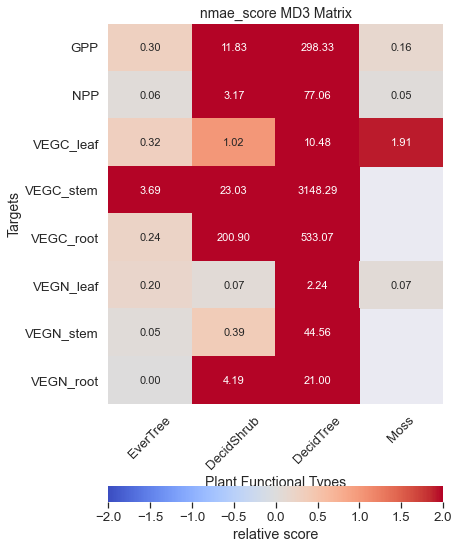

In [17]:
plot_MD3(rmetric='r2rmsemape', nelem=10, order=False, metric='nmae_score',site='MD3')

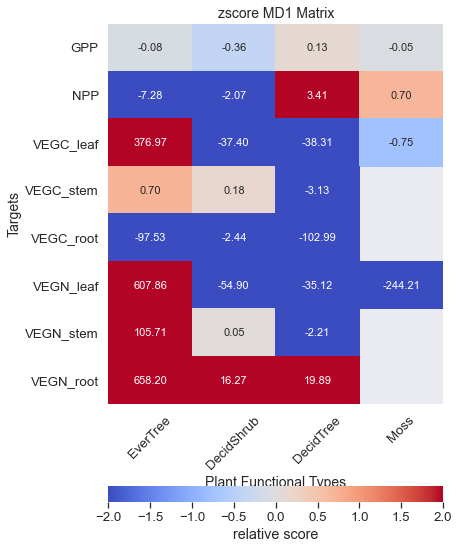

In [18]:
# Load MD1
def plot_MD1(rmetric='r2rmse', nelem=10, order=True, metric='zscore', site=''):
    # metric: zscore, nmae_score
    #GPP
    sa_folder = 'SA-MD1-STEP1/'

    [df_param_MD1,df_model_MD1]=read_samples_resutls(path_MD1+sa_folder+samples,
                                                     path_MD1+sa_folder+results)
    output_name_MD1 = ['GPP0','GPP1','GPP2','GPP3']
    df_model_MD1.columns = output_name_MD1
    xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param_MD1,df_model_MD1)

    if metric == 'zscore':
        gpp_md1 = z_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)
    else:
        gpp_md1 = nmae_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)
        
    gpp_md1=get_by_index(gpp_md1,['GPP0','GPP1','GPP2','GPP3'])

    # NPP
    sa_folder = 'SA-MD1-STEP2/'
    [df_param_MD1,df_model_MD1]=read_samples_resutls(path_MD1+sa_folder+samples,
                                                     path_MD1+sa_folder+'results.csv')
    output_name_MD1 = ['NPP0','NPP1','NPP2','NPP3',\
                       'VEGC00','VEGC10','VEGC20',\
                       'VEGC01','VEGC11','VEGC21',\
                       'VEGC02','VEGC12','VEGC22',\
                       'VEGC03'
                       ]
    df_model_MD1.columns = output_name_MD1
    xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param_MD1,df_model_MD1)

    if metric == 'zscore':
        npp_md1 = z_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)
    else:
        npp_md1 = nmae_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)
        
    npp_md1=get_by_index(npp_md1,['NPP0','NPP1','NPP2','NPP3'])

    #VEGC
    sa_folder = 'SA-MD1-STEP2/'
    [df_param_MD1,df_model_MD1]=read_samples_resutls(path_MD1+sa_folder+samples,
                                                     path_MD1+sa_folder+'results.csv')
    model_name = ['NPP0','NPP1','NPP2','NPP3',
                  'VEGC00','VEGC10','VEGC20',
                  'VEGC01','VEGC11','VEGC21',
                  'VEGC02','VEGC12','VEGC22','VEGC03']
    df_model_MD1.columns = model_name
    xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param_MD1,df_model_MD1)
    
    if metric == 'zscore':
        vegc_md1 = z_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)
    else:
        vegc_md1 = nmae_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)

    vegc_md1_leaf=get_by_index(vegc_md1,['VEGC00','VEGC01','VEGC02','VEGC03'])
    vegc_md1_stem=get_by_index(vegc_md1,['VEGC10','VEGC11','VEGC12'])
    vegc_md1_root=get_by_index(vegc_md1,['VEGC20','VEGC21','VEGC22'])


    #VEGN
    sa_folder = 'SA-STEP3-MD1-NPPVEGCVEGN-nfall-075/'
    [df_param_MD1,df_model_MD1]=read_samples_resutls(path_MD1+sa_folder+samples,
                                                     path_MD1+sa_folder+'results.csv')
    model_name = ['NPP0','NPP1','NPP2','NPP3',
                  'VEGC00','VEGC10','VEGC20',
                  'VEGC01','VEGC11','VEGC21',
                  'VEGC02','VEGC12','VEGC22','VEGC03',
                  'VEGN00','VEGN10','VEGN20',
                  'VEGN01','VEGN11','VEGN21',
                  'VEGN02','VEGN12','VEGN22','VEGN03',]
    df_model_MD1.columns = model_name
    xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param_MD1,df_model_MD1)
    
    if metric == 'zscore':
        vegc_md1 = z_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)
    else:
        vegc_md1 = nmae_score(ymodel_MD1.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_MD1)    
    
    vegn_md1_leaf=get_by_index(vegc_md1,['VEGN00','VEGN01','VEGN02','VEGN03'])
    vegn_md1_stem=get_by_index(vegc_md1,['VEGN10','VEGN11','VEGN12'])
    vegn_md1_root=get_by_index(vegc_md1,['VEGN20','VEGN21','VEGN22'])

    #new
    z_md1_matrix = pd.DataFrame({
             'GPP': gpp_md1,
             'NPP': npp_md1,
             'VEGC_leaf': vegc_md1_leaf, 'VEGC_stem': vegc_md1_stem, 'VEGC_root': vegc_md1_root,
             'VEGN_leaf': vegn_md1_leaf, 'VEGN_stem': vegn_md1_stem, 'VEGN_root': vegn_md1_root
            })
    z_md1_matrix.index=['EverTree', 'DecidShrub', 'DecidTree', 'Moss']

    site_metric_matrix(z_md1_matrix.T, metric+' '+site)
    
plot_MD1(rmetric, nelem, order, metric='zscore', site='MD1')


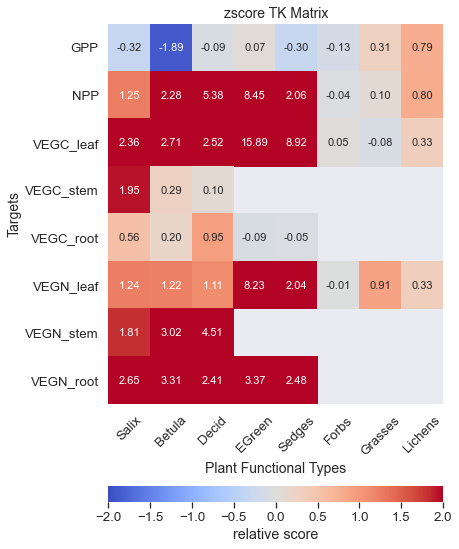

In [23]:
# Load TK1
def plot_TK(rmetric='r2rmse', nelem=10, order=True, metric='zscore', site=''):
    # metric: zscore, nmae_score
    #GPP
    sa_folder = 'sa-cmax-TK-075-EJ/'
    [df_param_TK,df_model_TK]=read_samples_resutls(path_TK+sa_folder+samples,
                                                   path_TK+sa_folder+'results.csv')
    output_name_TK = ['GPP0','GPP1','GPP2','GPP3','GPP4','GPP5','GPP6','GPP7']
    df_model_TK.columns = output_name_TK
    xparams_TK, ymodel_TK =  ut.get_best_match(df_param_TK,df_model_TK)

    if metric == 'zscore':
        gpp_tk = z_score(ymodel_TK.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_TK)
    else:
        gpp_tk = nmae_score(ymodel_TK.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_TK)
        
    gpp_tk=get_by_index(gpp_tk,['GPP0','GPP1','GPP2','GPP3','GPP4','GPP5','GPP6','GPP7'])
    
    # NPP
    sa_folder = 'sa-krb-NPPVEGC-TK-EJ-075/'
    [df_param_TK,df_model_TK]=read_samples_resutls(path_TK+sa_folder+samples,
                                                   path_TK+sa_folder+'results.csv')
    model_name = ['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6','NPP7', \
                  'VEGC00','VEGC10','VEGC20', 
                  'VEGC01','VEGC11','VEGC21',
                  'VEGC02','VEGC12','VEGC22',
                  'VEGC03','VEGC23','VEGC04','VEGC24','VEGC05','VEGC06','VEGC07']
    df_model_TK.columns = model_name
    xparams_TK, ymodel_TK =  ut.get_best_match(df_param_TK,df_model_TK)
    
    if metric == 'zscore':
        npp_tk = z_score(ymodel_TK.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_TK)
    else:
        npp_tk = nmae_score(ymodel_TK.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_TK)    
     
    npp_tk=get_by_index(npp_tk,['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6','NPP7'])    
    
    # VEGC
    sa_folder = 'sa-krb-NPPVEGC-TK-EJ-075/'
    [df_param_TK,df_model_TK]=read_samples_resutls(path_TK+sa_folder+samples,
                                                   path_TK+sa_folder+'results.csv')
    model_name = ['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6','NPP7', \
                  'VEGC00','VEGC10','VEGC20', 
                  'VEGC01','VEGC11','VEGC21',
                  'VEGC02','VEGC12','VEGC22',
                  'VEGC03','VEGC23','VEGC04','VEGC24','VEGC05','VEGC06','VEGC07']
    df_model_TK.columns = model_name   
    
    xparams_TK, ymodel_TK =  ut.get_best_match(df_param_TK,df_model_TK)
    
    z_tk = z_score(ymodel_TK.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_TK)
    vegc_tk_leaf=get_by_index(z_tk,['VEGC00','VEGC01','VEGC02','VEGC03','VEGC04','VEGC05','VEGC06','VEGC07'])
    vegc_tk_stem=get_by_index(z_tk,['VEGC10','VEGC11','VEGC12'])
    vegc_tk_root=get_by_index(z_tk,['VEGC20','VEGC21','VEGC22','VEGC23','VEGC24'])
    
    #VEGN
    sa_folder = 'sa-cfall-NPPVEGCN-TK-EJ-075/'
    [df_param_TK,df_model_TK]=read_samples_resutls(path_TK+sa_folder+samples,
                                                   path_TK+sa_folder+'results.csv')
    model_name = ['NPP0','NPP1','NPP2','NPP3','NPP4','NPP5','NPP6','NPP7', \
                  'VEGC00','VEGC10','VEGC20', 
                  'VEGC01','VEGC11','VEGC21',
                  'VEGC02','VEGC12','VEGC22',
                  'VEGC03','VEGC23','VEGC04','VEGC24','VEGC05','VEGC06','VEGC07',
                  'VEGN00','VEGN10','VEGN20', 
                  'VEGN01','VEGN11','VEGN21',
                  'VEGN02','VEGN12','VEGN22',
                  'VEGN03','VEGN23','VEGN04','VEGN24','VEGN05','VEGN06','VEGN07']
    df_model_TK.columns = model_name
    xparams_TK, ymodel_TK =  ut.get_best_match(df_param_TK,df_model_TK)
    
    z_tk = z_score(ymodel_TK.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_TK)
    vegn_tk_leaf=get_by_index(z_tk,['VEGN00','VEGN01','VEGN02','VEGN03','VEGN04','VEGN05','VEGN06','VEGN07'])
    vegn_tk_stem=get_by_index(z_tk,['VEGN10','VEGN11','VEGN12'])
    vegn_tk_root=get_by_index(z_tk,['VEGN20','VEGN21','VEGN22','VEGN23','VEGN24'])
    
    #new
    z_tk_matrix = pd.DataFrame({
             'GPP': gpp_tk,
             'NPP': npp_tk,
             'VEGC_leaf': vegc_tk_leaf, 'VEGC_stem': vegc_tk_stem, 'VEGC_root': vegc_tk_root,
             'VEGN_leaf': vegn_tk_leaf, 'VEGN_stem': vegn_tk_stem, 'VEGN_root': vegn_tk_root
            })
    z_tk_matrix.index=['Salix', 'Betula', 'Decid', 'EGreen', 'Sedges', 'Forbs', 'Grasses', 'Lichens']

    site_metric_matrix(z_tk_matrix.T, metric+' '+site)
    
plot_TK(rmetric, nelem, order, metric='zscore', site='TK')

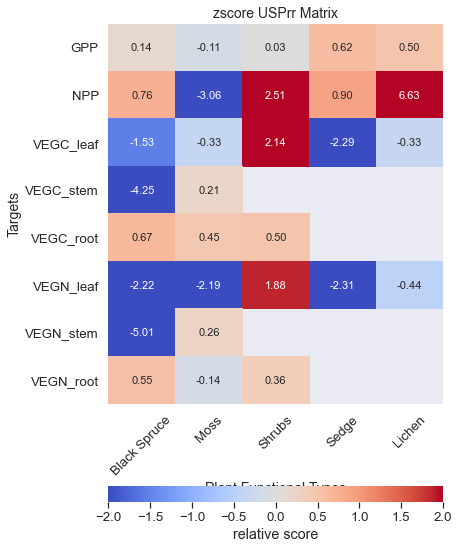

In [28]:
# Load US-Prr
def plot_USPrr(rmetric='r2rmse', nelem=10, order=True, metric='zscore', site=''):
    # metric: zscore, nmae_score
    #GPP

    sa_folder = 'STEP1-cmax-GPP/'
    [df_param_USPrr,df_model_USPrr]=read_samples_resutls(path_USPrr+sa_folder+samples,
                                                         path_USPrr+sa_folder+'results.csv')
    output_name_USPrr = ['GPP0','GPP1','GPP2','GPP3','GPP4']
    df_model_USPrr.columns = output_name_USPrr
    xparams_USPrr, ymodel_USPrr =  ut.get_best_match(df_param_USPrr,df_model_USPrr)
    
    if metric == 'zscore':
        gpp_USPrr = z_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_USPrr)
    else:
        gpp_USPrr = nmae_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_USPrr)

    gpp_USPrr=get_by_index(gpp_USPrr,['GPP0','GPP1','GPP2','GPP3','GPP4'])

    # NPP
    sa_folder = 'STEP2-nmax_krb-NPP_vegc/'
    [df_param_USPrr,df_model_USPrr]=read_samples_resutls(path_USPrr+sa_folder+samples,
                                                         path_USPrr+sa_folder+'results.csv')
    output_name_USPrr = ['NPP0','NPP1','NPP2','NPP3','NPP4',\
                         'VEGC00','VEGC10','VEGC20',\
                         'VEGC01',\
                         'VEGC02','VEGC12','VEGC22',\
                         'VEGC03','VEGC23',\
                         'VEGC04']

    df_model_USPrr.columns = output_name_USPrr
    xparams_USPrr, ymodel_USPrr =  ut.get_best_match(df_param_USPrr,df_model_USPrr)
    
    if metric == 'zscore':
        npp_USPrr = z_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_USPrr)
    else:
        npp_USPrr = nmae_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_USPrr)
    
    npp_USPrr=get_by_index(npp_USPrr,['NPP0','NPP1','NPP2','NPP3','NPP4'])
    
    
    # VEGC & N
    sa_folder = 'STEP3-nmax_krb_cfall_nfall-NPP_vegc_vegn/'
    [df_param_USPrr,df_model_USPrr]=read_samples_resutls(path_USPrr+sa_folder+samples,
                                                         path_USPrr+sa_folder+'results.csv')
    output_name_USPrr = ['NPP0','NPP1','NPP2','NPP3','NPP4',\
                         'VEGC00','VEGC10','VEGC20',\
                         'VEGC01',\
                         'VEGC02','VEGC12','VEGC22',\
                         'VEGC03','VEGC23',\
                         'VEGC04',
                         'VEGN00','VEGN10','VEGN20',\
                         'VEGN01',\
                         'VEGN02','VEGN12','VEGN22',\
                         'VEGN03','VEGN23',\
                         'VEGN04']

    df_model_USPrr.columns = output_name_USPrr
    xparams_USPrr, ymodel_USPrr =  ut.get_best_match(df_param_USPrr,df_model_USPrr)
    
    if metric == 'zscore':
        z_USPrr = z_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_USPrr)
    else:
        z_USPrr = nmae_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=order)[:nelem],
                        df_model_USPrr)
    
    vegc_USPrr_leaf=get_by_index(z_USPrr,['VEGC00','VEGC01','VEGC02','VEGC03','VEGC04'])
    vegc_USPrr_stem=get_by_index(z_USPrr,['VEGC10','VEGC12',])
    vegc_USPrr_root=get_by_index(z_USPrr,['VEGC20','VEGC22','VEGC23',])

    vegn_USPrr_leaf=get_by_index(z_USPrr,['VEGN00','VEGN01','VEGN02','VEGN03','VEGN04'])
    vegn_USPrr_stem=get_by_index(z_USPrr,['VEGN10','VEGN12',])
    vegn_USPrr_root=get_by_index(z_USPrr,['VEGN20','VEGN22','VEGN23',])
    
    #new
    z_USPrr_matrix = pd.DataFrame({
             'GPP': gpp_USPrr,
             'NPP': npp_USPrr,
             'VEGC_leaf': vegc_USPrr_leaf, 'VEGC_stem': vegc_USPrr_stem, 'VEGC_root': vegc_USPrr_root,
             'VEGN_leaf': vegn_USPrr_leaf, 'VEGN_stem': vegn_USPrr_stem, 'VEGN_root': vegn_USPrr_root
            })
    z_USPrr_matrix.index=['Black Spruce', 'Moss', 'Shrubs', 'Sedge', 'Lichen']

    site_metric_matrix(z_USPrr_matrix.T,  metric+' '+site)

plot_USPrr(rmetric, nelem, order, metric='zscore', site='USPrr')

# soil parameters -> below-ground targets (new)

In [33]:
#Load EML21
per_number=0.5
sa_folder = 'sa_soil_EML21_090_AK-2/'
df_param_EML = pd.read_csv(path_EML+sa_folder+samples)
df_model_EML = pd.read_csv(path_EML+sa_folder+results,header=None)

output_name = ['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum']
df_model_EML.columns = output_name

xparams_EML, ymodel_EML =  ut.get_best_match(df_param_EML,df_model_EML)

#Load MD3
sa_folder = 'sa_soil_MD3_090_AK/'
df_param_MD3 = pd.read_csv(path_MD3+sa_folder+samples)
df_model_MD3 = pd.read_csv(path_MD3+sa_folder+results,header=None)

df_model_MD3.columns = output_name

xparams_MD3, ymodel_MD3 =  ut.get_best_match(df_param_MD3,df_model_MD3)

#Load TK3
sa_folder = 'soilC-tk-EJ-095_case2/'
df_param_TK = pd.read_csv(path_TK+sa_folder+samples)
df_model_TK = pd.read_csv(path_TK+sa_folder+'results.csv',header=None)

df_model_TK.columns = output_name

xparams_TK, ymodel_TK =  ut.get_best_match(df_param_TK,df_model_TK)

#Load MD1
sa_folder = 'sa-step4-md1-soil-099-kdcsomcr-kdcsompr-fixed/'

[df_param_MD1,df_model_MD1]=read_samples_resutls(path_MD1+sa_folder+samples,
                                                 path_MD1+sa_folder+'results.csv')

output_name = ['NPP0','NPP1','NPP2','NPP3',
              'VEGC00','VEGC10','VEGC20',
              'VEGC01','VEGC11','VEGC21',
              'VEGC02','VEGC12','VEGC22','VEGC03',
              'VEGN00','VEGN10','VEGN20',
              'VEGN01','VEGN11','VEGN21',
              'VEGN02','VEGN12','VEGN22','VEGN03',
              'CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum']

df_model_MD1.columns = output_name
xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param_MD1,df_model_MD1)

# Load US-Prr
sa_folder = 'STEP4-soilC/'
[df_param_USPrr,df_model_USPrr]=read_samples_resutls(path_USPrr+sa_folder+samples,
                                                     path_USPrr+sa_folder+'results.csv')
output_name = ['CarbonShallow','CarbonDeep','CarbonMineralSum','OrganicNitrogenSum','AvailableNitrogenSum']
df_model_USPrr.columns = output_name

print(df_model_USPrr.isnull().values.any(),'have nans')
df_model_USPrr=df_model_USPrr.fillna(0)
xparams_USPrr, ymodel_USPrr =  ut.get_best_match(df_param_USPrr,df_model_USPrr)
xparams_USPrr

z_soil_tk = z_score(ymodel_TK.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_TK)
soil_tk=get_by_index(z_soil_tk,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_eml = z_score(ymodel_EML.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_EML)
soil_eml=get_by_index(z_soil_eml,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_md3 = z_score(ymodel_MD3.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_MD3)
soil_md3=get_by_index(z_soil_md3,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_md1 = z_score(ymodel_MD1.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_MD1)
soil_md1=get_by_index(z_soil_md1,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_USPrr = z_score(ymodel_USPrr.sort_values(by=[rmetric],ascending=True)[:nelem],df_model_USPrr)
soil_USPrr=get_by_index(z_soil_USPrr,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])

True have nans


# soil parameters -> below-ground targets

In [29]:
#Load EML21
per_number=0.5
sa_folder = 'sa_soil_EML21_090_AK-2/'
df_param_EML = pd.read_csv(path_EML+sa_folder+samples)
df_model_EML = pd.read_csv(path_EML+sa_folder+results,header=None)

output_name = ['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum']
df_model_EML.columns = output_name

xparams_EML, ymodel_EML =  ut.get_params_r2_rmse(df_param_EML,df_model_EML,r2lim=per_number)

#Load MD3
sa_folder = 'sa_soil_MD3_090_AK/'
df_param_MD3 = pd.read_csv(path_MD3+sa_folder+samples)
df_model_MD3 = pd.read_csv(path_MD3+sa_folder+results,header=None)

df_model_MD3.columns = output_name

xparams_MD3, ymodel_MD3 =  ut.get_params_r2_rmse(df_param_MD3,df_model_MD3,r2lim=per_number)

#Load TK3
sa_folder = 'soilC-tk-EJ-095_case2/'
df_param_TK = pd.read_csv(path_TK+sa_folder+samples)
df_model_TK = pd.read_csv(path_TK+sa_folder+'results.csv',header=None)

df_model_TK.columns = output_name

xparams_TK, ymodel_TK =  ut.get_params_r2_rmse(df_param_TK,df_model_TK,r2lim=.45)

#Load MD1
sa_folder = 'sa-step4-md1-soil-099-kdcsomcr-kdcsompr-fixed/'

[df_param_MD1,df_model_MD1]=read_samples_resutls(path_MD1+sa_folder+samples,
                                                 path_MD1+sa_folder+'results.csv')

output_name = ['NPP0','NPP1','NPP2','NPP3',
              'VEGC00','VEGC10','VEGC20',
              'VEGC01','VEGC11','VEGC21',
              'VEGC02','VEGC12','VEGC22','VEGC03',
              'VEGN00','VEGN10','VEGN20',
              'VEGN01','VEGN11','VEGN21',
              'VEGN02','VEGN12','VEGN22','VEGN03',
              'CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum']

df_model_MD1.columns = output_name
xparams_MD1, ymodel_MD1 =  ut.get_params_r2_rmse(df_param_MD1,df_model_MD1,r2lim=.98)

# Load US-Prr
sa_folder = 'STEP4-soilC/'
[df_param_USPrr,df_model_USPrr]=read_samples_resutls(path_USPrr+sa_folder+samples,
                                                     path_USPrr+sa_folder+'results.csv')
output_name = ['CarbonShallow','CarbonDeep','CarbonMineralSum','OrganicNitrogenSum','AvailableNitrogenSum']
df_model_USPrr.columns = output_name

print(df_model_USPrr.isnull().values.any(),'have nans')
df_model_USPrr=df_model_USPrr.fillna(0)
xparams_USPrr, ymodel_USPrr =  ut.get_params_r2_rmse(df_param_USPrr,df_model_USPrr,r2lim=0.94)
xparams_USPrr

z_soil_tk = z_score(ymodel_TK,df_model_TK)
soil_tk=get_by_index(z_soil_tk,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_eml = z_score(ymodel_EML,df_model_EML)
soil_eml=get_by_index(z_soil_eml,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_md3 = z_score(ymodel_MD3,df_model_MD3)
soil_md3=get_by_index(z_soil_md3,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_md1 = z_score(ymodel_MD1,df_model_MD1)
soil_md1=get_by_index(z_soil_md1,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])
z_soil_USPrr = z_score(ymodel_USPrr,df_model_USPrr)
soil_USPrr=get_by_index(z_soil_USPrr,['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum'])

True have nans


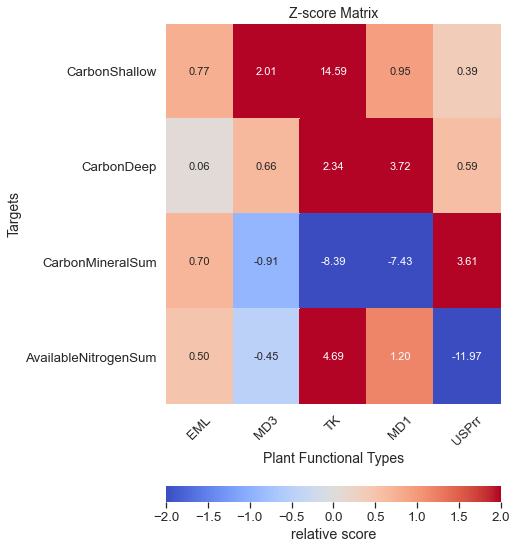

In [30]:
#new
z_matrix_soil = pd.DataFrame({'EML': soil_eml,'MD3': soil_md3,'TK': soil_tk, 'MD1': soil_md1,
                             'USPrr': soil_USPrr})
z_matrix_soil.index=['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum']
site_metric_matrix(z_matrix_soil, 'Z-score')

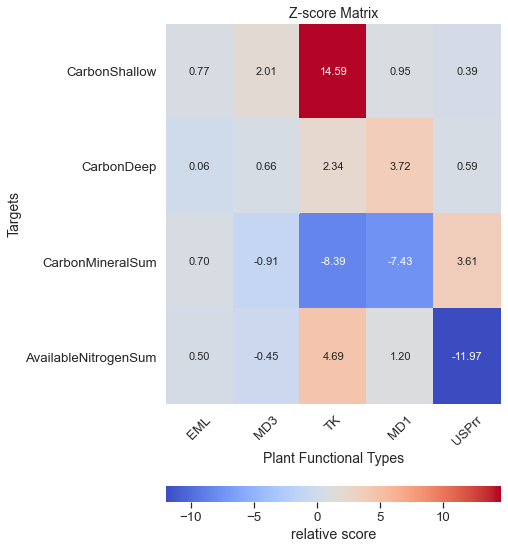

In [30]:
z_matrix_soil = pd.DataFrame({'EML': soil_eml,'MD3': soil_md3,'TK': soil_tk, 'MD1': soil_md1,
                             'USPrr': soil_USPrr})
z_matrix_soil.index=['CarbonShallow','CarbonDeep','CarbonMineralSum','AvailableNitrogenSum']
site_metric_matrix(z_matrix_soil, 'Z-score')

In [7]:
xparams_USPrr, ymodel_USPrr =  ut.get_best_match(df_param_USPrr,df_model_USPrr)
xparams_USPrr.sort_values(by=['r2rmse'],ascending=True)[:10]
ymodel_USPrr.sort_values(by=['r2rmse'],ascending=True)[:10]

,CarbonShallow,CarbonDeep,CarbonMineralSum,OrganicNitrogenSum,AvailableNitrogenSum,R2,RMSE,MAPE,COMBINED_ACC,r2rmse,r2rmsemape
144,3834.061786,22278.280386,49911.418377,2823.786567,0.149425,0.987376,4.460832e+06,8.089445,0.987376,0.013144,0.013144
162,3484.513708,24851.822110,50253.092351,2896.680871,0.108647,0.982484,6.430261e+06,11.228515,0.981673,0.018293,0.018293
5,3707.599231,24212.258169,50656.203214,2859.068558,0.349605,0.981986,6.657491e+06,3.399960,0.981082,0.018823,0.018823
63,3945.184791,25481.559361,50224.174105,2944.292219,0.066926,0.981016,6.954125e+06,18.268562,0.979990,0.019822,0.019822
400,3783.946380,25842.839793,49989.822731,2910.114642,0.113256,0.980854,6.997705e+06,10.754573,0.979810,0.019987,0.019987
119,3143.662085,24637.283890,51586.186471,2898.112690,0.062015,0.975656,9.410754e+06,19.777004,0.973619,0.025538,0.025538
410,7175.633894,21804.660507,51744.567333,2767.902305,0.011037,0.972039,1.016607e+07,111.427513,0.969691,0.029178,0.029178
495,4603.189456,29251.019130,50283.544366,3186.458782,1.756551,0.961446,1.457529e+07,0.605648,0.957283,0.040364,0.040364
41,3839.400087,17214.643753,52124.120461,2846.375719,0.077594,0.960221,1.495819e+07,15.782374,0.955901,0.041627,0.041627
3,8549.167647,20590.222964,52497.666460,2782.976646,0.037583,0.959818,1.475031e+07,32.693213,0.955584,0.041963,0.041963


In [98]:
ymodel_USPrr.sort_values(by=['R2'],ascending=False)[:10]

,CarbonShallow,CarbonDeep,CarbonMineralSum,OrganicNitrogenSum,AvailableNitrogenSum,R2,RMSE,MAPE,COMBINED_ACC,r2rmse,r2rmsemape
144,3834.061786,22278.280386,49911.418377,2823.786567,0.149425,0.987376,4.460832e+06,8.089445,0.987376,0.013144,0.013144
162,3484.513708,24851.822110,50253.092351,2896.680871,0.108647,0.982484,6.430261e+06,11.228515,0.981673,0.018293,0.018293
5,3707.599231,24212.258169,50656.203214,2859.068558,0.349605,0.981986,6.657491e+06,3.399960,0.981082,0.018823,0.018823
63,3945.184791,25481.559361,50224.174105,2944.292219,0.066926,0.981016,6.954125e+06,18.268562,0.979990,0.019822,0.019822
400,3783.946380,25842.839793,49989.822731,2910.114642,0.113256,0.980854,6.997705e+06,10.754573,0.979810,0.019987,0.019987
119,3143.662085,24637.283890,51586.186471,2898.112690,0.062015,0.975656,9.410754e+06,19.777004,0.973619,0.025538,0.025538
410,7175.633894,21804.660507,51744.567333,2767.902305,0.011037,0.972039,1.016607e+07,111.427513,0.969691,0.029178,0.029178
495,4603.189456,29251.019130,50283.544366,3186.458782,1.756551,0.961446,1.457529e+07,0.605648,0.957283,0.040364,0.040364
41,3839.400087,17214.643753,52124.120461,2846.375719,0.077594,0.960221,1.495819e+07,15.782374,0.955901,0.041627,0.041627
3,8549.167647,20590.222964,52497.666460,2782.976646,0.037583,0.959818,1.475031e+07,32.693213,0.955584,0.041963,0.041963


In [83]:
xparams_USPrr.sort_values(by=['r2rmsemape'],ascending=True)[:10]

,micbnup,kdcrawc,kdcsoma,kdcsompr,kdcsomcr,R2,RMSE,MAPE,COMBINED_ACC,r2rmse,r2rmsemape
144,1.034717,0.159833,0.071426,0.005763,0.000017,0.987376,4.460832e+06,8.089445,0.987376,0.013144,0.013144
162,1.448248,0.650197,0.568469,0.003083,0.000022,0.982484,6.430261e+06,11.228515,0.981673,0.018293,0.018293
5,0.564732,0.208677,0.766171,0.003207,0.000100,0.981986,6.657491e+06,3.399960,0.981082,0.018823,0.018823
63,1.545538,0.493957,0.014622,0.003251,0.000036,0.981016,6.954125e+06,18.268562,0.979990,0.019822,0.019822
400,1.202606,0.508619,0.234107,0.002610,0.000050,0.980854,6.997705e+06,10.754573,0.979810,0.019987,0.019987
119,1.348196,0.967239,0.086005,0.003072,0.000043,0.975656,9.410754e+06,19.777004,0.973619,0.025538,0.025538
410,1.866178,0.020034,0.127258,0.221657,0.000046,0.972039,1.016607e+07,111.427513,0.969691,0.029178,0.029178
495,0.898986,0.122303,0.168754,0.001235,0.000004,0.961446,1.457529e+07,0.605648,0.957283,0.040364,0.040364
41,1.616240,0.119093,0.216138,0.005371,0.000029,0.960221,1.495819e+07,15.782374,0.955901,0.041627,0.041627
3,1.853501,0.019023,0.384091,0.172243,0.000072,0.959818,1.475031e+07,32.693213,0.955584,0.041963,0.041963
